In [64]:
import sqlite3
import pathlib
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyproj import Transformer

In [65]:
#transformer = Transformer.from_crs("EPSG:4326","EPSG:3857")
transformer = Transformer.from_crs("EPSG:4326","esri:54030")
def project_latlon_mercator(input_coords:tuple)->tuple:
    ''' This function takes in a set of lon/lat coordinates and
    performs the mercator projection on them, in order to display them correctly
    on a map'''
    lon = input_coords[0]
    lat = input_coords[1]
    x,y = transformer.transform(lon, lat)
    output_coords = (y,x)
    return output_coords

In [66]:
# Locating files
current_file_path = pathlib.Path().resolve()
base_folder = current_file_path.parents[0]
database_path = base_folder.joinpath('2. Data\\Database\\nrdp_fare_data.db')

In [67]:
# reading database table into a dataframe
db_conn = sqlite3.connect(database_path)
flow_fare_loc_df = pd.read_sql_query('SELECT * FROM flow_fare_location', db_conn)
db_conn.close()

In [68]:
flow_fare_loc_df['ORIGIN_COORDS'] = list(zip(flow_fare_loc_df.ORIGIN_LON,flow_fare_loc_df.ORIGIN_LAT))
flow_fare_loc_df['DESTINATION_COORDS'] = list(zip(flow_fare_loc_df.DESTINATION_LON,flow_fare_loc_df.DESTINATION_LAT))
network_df = flow_fare_loc_df[['ORIGIN_CODE','DESTINATION_CODE','FARE_POUNDS','ORIGIN_COORDS','DESTINATION_COORDS']].copy()
network_df['ORIGIN_COORDS'] = network_df['ORIGIN_COORDS'].apply(project_latlon_mercator)
network_df['DESTINATION_COORDS'] = network_df['DESTINATION_COORDS'].apply(project_latlon_mercator)

In [69]:
stations = {}
routes = []
for i in range(len(network_df)):
    stations[network_df['ORIGIN_CODE'][i]]=network_df['ORIGIN_COORDS'][i]
    stations[network_df['DESTINATION_CODE'][i]]=network_df['DESTINATION_COORDS'][i]
    routes.append((network_df['ORIGIN_CODE'][i],network_df['DESTINATION_CODE'][i],network_df['FARE_POUNDS'][i]))

In [70]:
# Forming graph
G = nx.Graph()
for i in range(len(routes)):
    G.add_edge(stations[routes[i][0]],stations[routes[i][1]],weight=routes[i][2])
pos = {value:value for key, value in stations.items()} # Creates nodes in graph

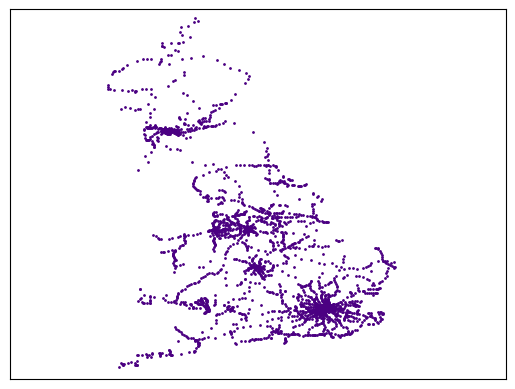

In [71]:
# Displaying graph
fig, ax = plt.subplots()
nx.draw_networkx_nodes(G, pos=pos, node_color='indigo', ax=ax, node_size=1)
#nx.draw_networkx_labels(G, pos=pos) #draw node labels
#labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, ax=ax)
plt.axis("on")
ax.set_xlim(-900000,500000)
ax.set_ylim(4700000,5550000)
plt.show()